# Skin Cancer Detection

In this notebook we are going to try finding out if a mole can be considered skin cancer or not.

To do this we are using the HAM 10000 dataset.
The dataset can be downloaded from https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000

In [225]:
import torch as t
import torch.nn as nn
import torchvision.transforms.functional as F

import pandas as pd
import numpy as np
import random

device = 'cuda' if t.cuda.is_available() else 'cpu'
print(f"using device: {device}")

# Reproducibility -> Also ensures same train / validation / test split every time
t.manual_seed(42)
random.seed(42)
np.random.seed(42)

t.cuda.empty_cache()

using device: cuda


## Utility function to display images

Taken from pytorch official torchvision docs

In [226]:
import matplotlib.pyplot as plt

plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img, mode='RGB')
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

# Target Classes

As a memo, please recall that the target values are gathered in the column called 'dx' and they can have the following values:

- 'nv' = Melanocytic nevi
- 'mel' = Melanoma
- 'bkl' = Benign keratosis-like lesions
- 'bcc' = Basal cell carcinoma
- 'akiec' = Actinic keratoses
- 'vasc' = Vascular lesions
- 'df' = Dermatofibroma



In [266]:
from sklearn.preprocessing import LabelEncoder
from torchvision.io import decode_image
import torchvision as tv
import os

class HAM10000Dataset(t.utils.data.Dataset):
    def __init__(self, data_path, max_attempts = 100):
        self.data_path = data_path
        self.df = pd.read_csv(data_path + '/HAM10000_metadata.csv')
        self.label_encoder = LabelEncoder()
        encoded_targets = self.label_encoder.fit_transform(self.df['dx'])
        self.df['dx_numeric'] = encoded_targets.tolist()
        self.image_transformer = tv.transforms.Compose([
            tv.transforms.RandomRotation(10),
            tv.transforms.RandomHorizontalFlip(),
            tv.transforms.RandomVerticalFlip(),
            tv.transforms.Resize((200, 200), antialias=True),
        ])
        self.max_attempts = max_attempts
    
    def __len__(self):
        E, _ = self.df.shape
        return E

    def get_diagnosis_from_label(self, labels):
        return self.label_encoder.inverse_transform(labels)
    
    def __getitem__(self, index):
        attempts = 0
        while attempts < self.max_attempts:
            try:
                target = self.df['dx_numeric'].iloc[index]
                filename = '/HAM10000_images/' + self.df['image_id'].iloc[index] + '.jpg'
                a = os.path.expanduser(self.data_path)
                image = decode_image(a + filename)
                image = self.image_transformer(image)
                return image, target
            except (FileNotFoundError):
                print(f'Error opening the image at path {a + filename}')
                attempts += 1
                index = random.randint(0, len(self) - 1)
        raise Exception(f'Critical Error: Cannot load Dataset')

data_destination_path = '~/Documents/github/MachineLearning/SkinCancerDetection/data'
dataset = HAM10000Dataset(data_destination_path)

Image #1: torch.Size([3, 200, 200]), diagnosis: ['bkl']
Image #2: torch.Size([3, 200, 200]), diagnosis: ['bkl']


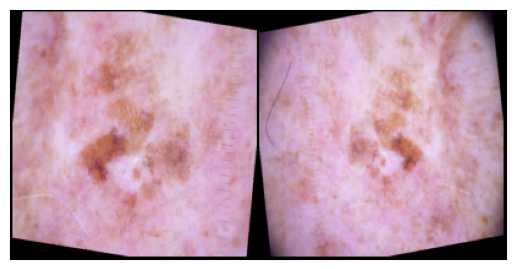

In [267]:
from torchvision.utils import make_grid

image_1, target_1 = dataset[0]
image_2, target_2 = dataset[1]

grid = make_grid([image_1, image_2])
show(grid)
print(f'Image #1: {image_1.shape}, diagnosis: {dataset.get_diagnosis_from_label([target_1])}')
print(f'Image #2: {image_2.shape}, diagnosis: {dataset.get_diagnosis_from_label([target_2])}')